In [93]:
import pandas as pd
import numpy as np

from src.OLS import OLS
from src.StandardScaler import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
s = StandardScaler()
rgdp = pd.read_csv('./data/fred/GDPC1.csv', low_memory=False, encoding='utf-8')
tcu = pd.read_csv('./data/fred/TCU.csv', low_memory=False, encoding='utf-8')
fedrate = pd.read_csv('./data/fred/DFF.csv', low_memory=False, encoding='utf-8')

set = [rgdp, tcu, fedrate]
for df in set:
    df.set_index("observation_date", inplace=True)


<Axes: >

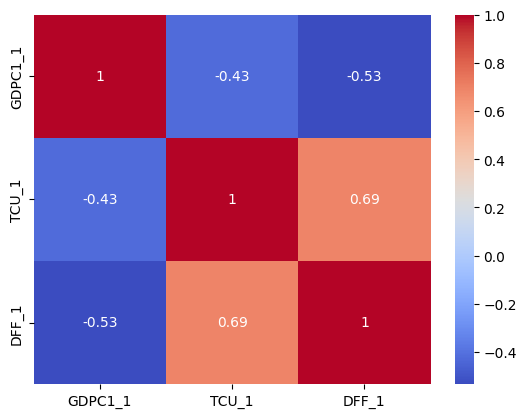

In [122]:
target = pd.Series(rgdp['GDPC1'])
X = pd.concat([rgdp, tcu.loc[rgdp.index], fedrate.loc[rgdp.index]], axis=1)
X = X.shift(1).dropna(how='any')
cols = X.columns.tolist()
X.columns = [col + "_1" for col in cols]
X_2 = X.shift(1)

target = target.loc[X.index]

assert X.notna().all().all() == target.notna().all().all() == True, len(X) == len(target)
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

In [123]:
# House Price Data Prep
# yn_map = {"yes": 1, "no": 0}
y = target.values
X = X.values

In [124]:
# X_test = X[-1]
# y_yest = y[-1]

X_fit = X
y_fit = y

ols = OLS(X_fit, y_fit)
fit = ols.fit(diagnosis_trend="ctt")
fit.fitted_values

array([10131.44469995, 10164.75354408, 10173.20999108, 10089.1116197 ,
       10055.19572755, 10152.80249666, 10183.00653427, 10207.76607876,
       10338.19913861, 10435.85652713, 10524.59189051, 10633.83956961,
       10641.7585485 , 10705.15238361, 10759.39487963, 10897.15850008,
       10992.18959298, 11135.28198217, 11197.09590822, 11325.32799078,
       11352.1855917 , 11407.44216893, 11510.24686898, 11584.15239559,
       11675.41210157, 11863.23058074, 11981.63625234, 12094.71719075,
       12174.05800546, 12370.94270966, 12522.5719317 , 12614.03835155,
       12744.72454711, 12877.35653863, 13066.26532191, 13258.4001504 ,
       13378.92380962, 13500.26428072, 13679.92004001, 13897.34303212,
       13937.35814085, 14199.30583446, 14227.1187141 , 14323.28446463,
       14289.19275048, 14400.72830031, 14361.86415275, 14412.13860906,
       14527.08266842, 14608.44537927, 14655.96248181, 14676.75393314,
       14739.45720717, 14876.45621748, 15112.89414892, 15280.2242495 ,
      

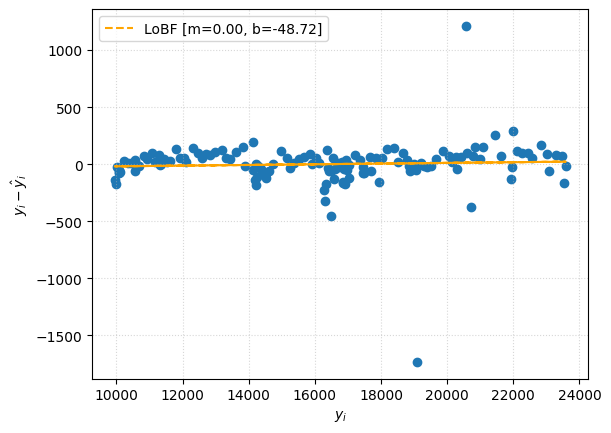

In [125]:
n = len(fit.resid)
m, b = np.polyfit(y_fit, fit.resid, 1)

line = m * y_fit + b


plt.scatter(y_fit, fit.resid)
plt.plot(y_fit, line, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle="--", color="orange")

plt.xlabel(r"$y_i$")
plt.ylabel(r"$y_i - \hat{y}_i$")

plt.grid(alpha=0.5, linestyle=":")

plt.legend()
plt.show()

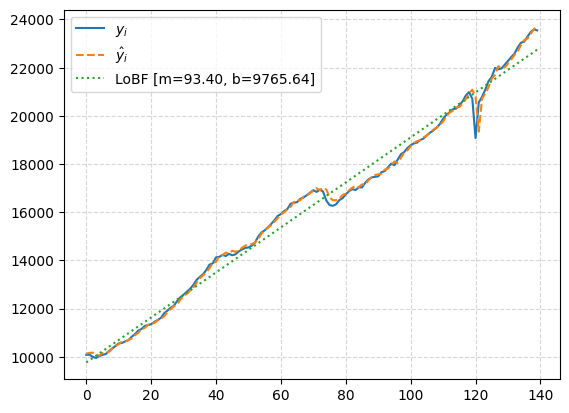

In [133]:
x = np.array([i for i in range(len(y_fit))])
m, b = np.polyfit(x, y_fit, 1)
plt.plot(x, y_fit, label=r"$y_i$")
plt.plot(x, fit.fitted_values, label=r"$\hat{y}_i$", linestyle="--")
plt.plot(x, m*x + b, label=f"LoBF [{m=:.2f}, {b=:.2f}]", linestyle=":")

plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.show()

In [101]:
fit.resid_heteroske

reject: False
pval: 0.8318732027853051
test_stat: 5.05063403519054
stat_name: Breusch-Pagan Test (Chi^2 Statistic)

In [102]:
# print(ols.predict(X_test))
fit.resid_normality

reject: False
pval: 0.9321945202336483
test_stat: 0.9875513290714806
stat_name: Shapiro-Wilk Test (Approximated Z-Statistic)

In [103]:
fit.resid_stationarity

reject: False
pval: 0.8933807224608612
test_stat: -1.7601428571144435
stat_name: ADF Test (T-Statistic)

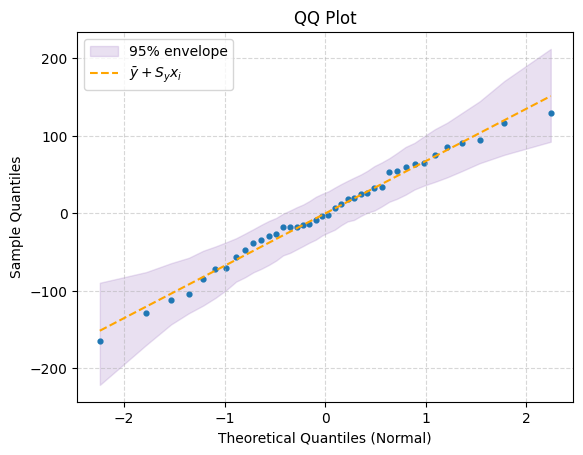

In [104]:
fit.qq(line="45", band=0.95)

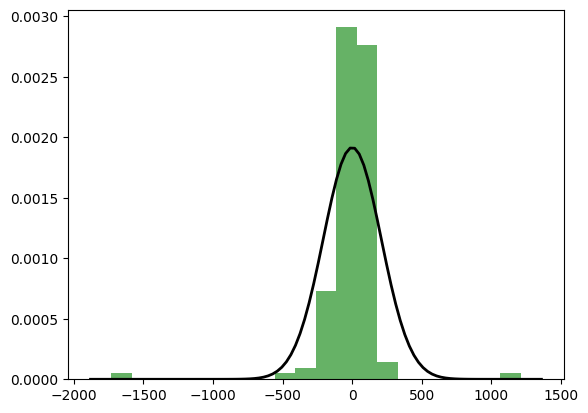

In [131]:
from scipy.stats import norm
plt.hist(fit.resid, bins=20, density=True, alpha=0.6, color='g')
mu, std = norm.fit(fit.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [127]:
fit.error

R2: 0.997
R2_ADJ: 0.9969
RMSE: 208.0983
MAPE: 0.006